Manually Reduce Number of Categories In Each Feature

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

from matplotlib import cm
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from feature_processing import (create_contingency_table,
                                calculate_conditional_prob_bin,
                                encode_my_categorical_labels,
                                calculate_conditional_prob_cat,
                                estimate_cond_prob_density,
                                bin_myFeature)
import feature_analysis as fa

/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from importlib import reload

In [3]:
train = pd.read_csv('train.csv', header=0)
test = pd.read_csv('test.csv', header=0)

# Get different kinds of features
all_fs = train.columns[:-1]
binary_fs = sorted([f for f in all_fs if '_bin' in f])
categorical_fs = sorted([f for f in all_fs if '_cat' in f])
other_fs = sorted([f for f in all_fs
            if f not in binary_fs
            if f not in categorical_fs])
bincat_fs = binary_fs + categorical_fs
categoricals = train[categorical_fs]
binaries = train[binary_fs]

In [4]:
categoricals_test = test[categorical_fs]

In [5]:
for f in categorical_fs:
    print('%s: # unique values: %d' % (f, len(categoricals[f].unique())))

ps_car_01_cat: # unique values: 13
ps_car_02_cat: # unique values: 3
ps_car_03_cat: # unique values: 3
ps_car_04_cat: # unique values: 10
ps_car_05_cat: # unique values: 3
ps_car_06_cat: # unique values: 18
ps_car_07_cat: # unique values: 3
ps_car_08_cat: # unique values: 2
ps_car_09_cat: # unique values: 6
ps_car_10_cat: # unique values: 3
ps_car_11_cat: # unique values: 104
ps_ind_02_cat: # unique values: 5
ps_ind_04_cat: # unique values: 3
ps_ind_05_cat: # unique values: 8


In [6]:
reload(fa)

<module 'feature_analysis' from '/home/ryohayama/python_current/porto_seguro/feature_analysis.py'>

In [7]:
target = train.target

<b>Check for any difference in frequencies of categories in each feature between train and test set</b>

In [8]:
# Use fa.Feature class, express difference in percentage
for i, f in enumerate(bincat_fs):
    train_data = fa.Feature(train[f]).value_frequencies_
    test_data = fa.Feature(test[f]).value_frequencies_
    train_data.rename({f: (f+ '_train')})
    test_data.rename({f: (f+ '_test')})
    comparison = pd.concat([train_data, test_data], axis=1)
    comparison['percent_difference'] = 100*(comparison.iloc[:, 0] - comparison.iloc[:, 1])
    print('==== %s ====' % f)
    print(comparison)
    print('\n')

==== ps_calc_15_bin ====
   ps_calc_15_bin  ps_calc_15_bin  percent_difference
0        0.877573         0.87628            0.129281
1        0.122427         0.12372           -0.129281


==== ps_calc_16_bin ====
   ps_calc_16_bin  ps_calc_16_bin  percent_difference
1         0.62784        0.627756            0.008372
0         0.37216        0.372244           -0.008372


==== ps_calc_17_bin ====
   ps_calc_17_bin  ps_calc_17_bin  percent_difference
1        0.554182         0.55466           -0.047726
0        0.445818         0.44534            0.047726


==== ps_calc_18_bin ====
   ps_calc_18_bin  ps_calc_18_bin  percent_difference
0        0.712818        0.712204            0.061443
1        0.287182        0.287796           -0.061443


==== ps_calc_19_bin ====
   ps_calc_19_bin  ps_calc_19_bin  percent_difference
0        0.650976        0.650656            0.032056
1        0.349024        0.349344           -0.032056


==== ps_ind_06_bin ====
   ps_ind_06_bin  ps_ind_06_bin

==== ps_ind_02_cat ====
    ps_ind_02_cat  ps_ind_02_cat  percent_difference
 1       0.725555       0.725198            0.035735
 2       0.207612       0.208524           -0.091275
 3       0.047355       0.047026            0.032807
 4       0.019116       0.018908            0.020829
-1       0.000363       0.000344            0.001904


==== ps_ind_04_cat ====
    ps_ind_04_cat  ps_ind_04_cat  percent_difference
 0       0.582927       0.582314            0.061304
 1       0.416934       0.417524           -0.059008
-1       0.000139       0.000162           -0.002296


==== ps_ind_05_cat ====
    ps_ind_05_cat  ps_ind_05_cat  percent_difference
-1       0.009760       0.009756            0.000390
 0       0.887094       0.886412            0.068180
 1       0.013982       0.013905            0.007613
 2       0.007029       0.007306           -0.027667
 3       0.013832       0.014024           -0.019212
 4       0.030819       0.030647            0.017242
 5       0.002770      

<b>It appears that the category frequencies are not significantly different among train and test sets, which is good!T he biggest different appears to be only 0.16% change. So I can go ahead and start combining categories for each feature.</b>

## Selection Criteria
- Calculate ratio of Conditional Probability of being in class1 to the bulk class1 frequency
- Create new categories by binning categories based on those ratios
- Criteria: <5% gain, 5-10% gain, 10-20% gain, 20% and above, etc. It's subjective...
- The new categorization will be expressed as lists lists where each of the inner lists contains the current categories   to be combined together. Also, those lists are sorted in the increasing order of conditional probabilities of being in   class1.

In [9]:
# ps_car_01_cat
print(fa.FeatureVsTarget(categoricals.ps_car_01_cat, target).calculate_deviation(mode='ratio')[0]-1)

target         0         1
-1     -0.291950  7.718207
 0     -0.007702  0.203609
 1     -0.010763  0.284528
 2     -0.006707  0.177322
 3     -0.001143  0.030216
 4     -0.002816  0.074449
 5     -0.002904  0.076780
 6      0.006937 -0.183402
 7      0.007968 -0.210636
 8     -0.007213  0.190687
 9     -0.018653  0.493136
 10    -0.000548  0.014491
 11    -0.005327  0.140834


6 Groups: [[6, 7], [3, 4, 5, 10], [2, 8, 11], [0, 1], [9], [-1]]

In [10]:
# ps_car_02_cat
print(fa.FeatureVsTarget(categoricals.ps_car_02_cat, target).calculate_deviation(mode='ratio')[0]-1)

target         0         1
-1      0.037826 -1.000000
 0     -0.013554  0.358323
 1      0.002777 -0.073409


2 Groups: [[-1, 1], [0]]

In [11]:
# ps_car_03_cat
print(fa.FeatureVsTarget(categoricals.ps_car_03_cat, target).calculate_deviation(mode='ratio')[0]-1)

target         0         1
-1      0.003882 -0.102636
 0     -0.003207  0.084782
 1     -0.012299  0.325132


No Change Needed

In [12]:
# ps_car_04_cat
print(fa.FeatureVsTarget(categoricals.ps_car_04_cat, target).calculate_deviation(mode='ratio')[0]-1)

target         0         1
0       0.003110 -0.082222
1      -0.012845  0.339585
2      -0.011162  0.295077
3      -0.015687  0.414705
4       0.015265 -0.403550
5      -0.036440  0.963361
6      -0.023379  0.618062
7      -0.059237  1.566023
8      -0.014221  0.375965
9      -0.026404  0.698037


5 Groups: [[0, 4], [1, 2, 3, 8], [6, 9], [5], [7]]

In [13]:
# ps_car_05_cat
print(fa.FeatureVsTarget(categoricals.ps_car_05_cat, target).calculate_deviation(mode='ratio')[0]-1)

target         0         1
-1      0.004918 -0.130016
 0     -0.003802  0.100501
 1     -0.004158  0.109913


2 Groups: [[-1], [0, 1]]

In [14]:
# ps_car_06_cat
print(fa.FeatureVsTarget(categoricals.ps_car_06_cat, target).calculate_deviation(mode='ratio')[0]-1)

target         0         1
0       0.003191 -0.084366
1       0.002348 -0.062082
2      -0.030630  0.809764
3      -0.001794  0.047430
4       0.002694 -0.071226
5      -0.031807  0.840864
6      -0.000366  0.009675
7      -0.002446  0.064663
8      -0.034204  0.904248
9      -0.019258  0.509120
10     -0.007947  0.210081
11      0.004907 -0.129715
12     -0.012630  0.333889
13     -0.021326  0.563796
14      0.002235 -0.059096
15     -0.015230  0.402641
16     -0.009059  0.239502
17     -0.028418  0.751279


5 Groups: [[0, 1, 4, 11, 14], [3, 6, 7], [10, 12, 16], [9, 13, 15], [2, 5, 8, 17]]

In [15]:
# ps_car_07_cat
print(fa.FeatureVsTarget(categoricals.ps_car_07_cat, target).calculate_deviation(mode='ratio')[0]-1)

target         0         1
-1     -0.043292  1.144500
 0     -0.015296  0.404365
 1      0.001745 -0.046123


No change needed

In [16]:
# ps_car_08_cat
print(fa.FeatureVsTarget(categoricals.ps_car_08_cat, target).calculate_deviation(mode='ratio')[0]-1)

target         0         1
0      -0.008807  0.232824
1       0.001777 -0.046986


No change needed (this is binary?)

In [17]:
# ps_car_09_cat
print(fa.FeatureVsTarget(categoricals.ps_car_09_cat, target).calculate_deviation(mode='ratio')[0]-1)

target         0         1
-1     -0.057019  1.507397
 0      0.003221 -0.085151
 1     -0.021274  0.562421
 2      0.000134 -0.003535
 3      0.001394 -0.036852
 4     -0.015415  0.407512


3 Groups: [[0, 2, 3], [1, 4], [-1]]

In [18]:
# ps_car_10_cat
print(fa.FeatureVsTarget(categoricals.ps_car_10_cat, target).calculate_deviation(mode='ratio')[0]-1)

target         0         1
0       0.002142 -0.056634
1      -0.000017  0.000439
2      -0.003451  0.091233


No change needed

<b>Come back to car_11 later because it has 104 categories</b>

In [19]:
# ps_ind_02_cat
print(fa.FeatureVsTarget(categoricals.ps_ind_02_cat, target).calculate_deviation(mode='ratio')[0]-1)

target         0         1
-1     -0.154364  4.080872
 1      0.000750 -0.019834
 2     -0.001756  0.046420
 3     -0.000799  0.021114
 4     -0.004497  0.118882


4 Groups: [[1], [2, 3], [4], [-1]]

In [20]:
# ps_ind_04_cat
print(fa.FeatureVsTarget(categoricals.ps_ind_04_cat, target).calculate_deviation(mode='ratio')[0]-1)

target         0         1
-1     -0.374804  9.908572
 0      0.001720 -0.045470
 1     -0.002279  0.060259


No change needed

In [21]:
# ps_ind_05_cat
print(fa.FeatureVsTarget(categoricals.ps_ind_05_cat, target).calculate_deviation(mode='ratio')[0]-1)

target         0         1
-1     -0.048644  1.285999
 0      0.002680 -0.070857
 1     -0.011808  0.312162
 2     -0.040556  1.072180
 3     -0.006798  0.179715
 4     -0.016204  0.428372
 5     -0.012523  0.331071
 6     -0.023754  0.627984


5 Groups: [[0], [3], [1, 4, 5], [6], [-1, 2]] 

In [22]:
cat_binning_dict = {
    'ps_car_01_cat': [[6, 7], [3, 4, 5, 10], [2, 8, 11], [0, 1], [9], [-1]],
    'ps_car_02_cat': [[-1, 1], [0]],
    'ps_car_04_cat': [[0, 4], [1, 2, 3, 8], [6, 9], [5], [7]],
    'ps_car_05_cat': [[-1], [0, 1]],
    'ps_car_06_cat': [[0, 1, 4, 11, 14], [3, 6, 7], [10, 12, 16], [9, 13, 15], [2, 5, 8, 17]],
    'ps_car_09_cat': [[0, 2, 3], [1, 4], [-1]],
    'ps_ind_02_cat': [[1], [2, 3], [4], [-1]],
    'ps_ind_05_cat': [[0], [3], [1, 4, 5], [6], [-1, 2]]
}

<b>ps_car_11_cat...</b>

In [23]:
car11 = fa.FeatureVsTarget(categoricals.ps_car_11_cat, target)

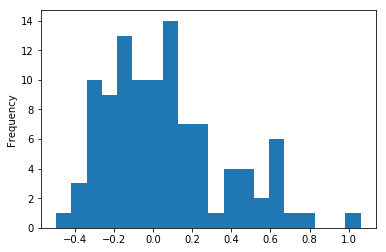

In [24]:
car11_proba_ratio = car11.calculate_deviation(mode='ratio')[0]-1
car11_proba_ratio[1].plot(kind='hist', bins=20)

I could bin them by treating ratio of conditional probas to that of bulk as a continuous variable. Cutoffs can be:<br>
p < -0.4<br>
-0.4 <= p < -0.2<br>
-0.2 <= p < 0<br>
0 <= p < 0.2<br>
0.2 <= p < 0.4<br>
0.4 <= p < 0.6<br>
0.6 <= p < 0.8<br>
p >= 0.8<br>
This would reduce number of categories from 104 to 8.

In [25]:
car11_cat1 = list(car11_proba_ratio[1][car11_proba_ratio[1] < -0.4].index)
car11_cat2 = list(car11_proba_ratio[1][(car11_proba_ratio[1] >= -0.4) & (car11_proba_ratio[1] < -0.2)].index)
car11_cat3 = list(car11_proba_ratio[1][(car11_proba_ratio[1] >= -0.2) & (car11_proba_ratio[1] < 0)].index)
car11_cat4 = list(car11_proba_ratio[1][(car11_proba_ratio[1] >= 0) & (car11_proba_ratio[1] < 0.2)].index)
car11_cat5 = list(car11_proba_ratio[1][(car11_proba_ratio[1] >= 0.2) & (car11_proba_ratio[1] < 0.4)].index)
car11_cat6 = list(car11_proba_ratio[1][(car11_proba_ratio[1] >= 0.4) & (car11_proba_ratio[1] < 0.6)].index)
car11_cat7 = list(car11_proba_ratio[1][(car11_proba_ratio[1] >= 0.6) & (car11_proba_ratio[1] < 0.8)].index)
car11_cat8 = list(car11_proba_ratio[1][car11_proba_ratio[1] >= 0.8].index)

In [26]:
cat_binning_dict['ps_car_11_cat'] = [
    car11_cat1, 
    car11_cat2, 
    car11_cat3, 
    car11_cat4, 
    car11_cat5, 
    car11_cat6, 
    car11_cat7, 
    car11_cat8 
]

In [27]:
# Make sure all the categories are accounted for
count = 0
for i in range(len(cat_binning_dict['ps_car_11_cat'])):
    count += len(cat_binning_dict['ps_car_11_cat'][i])
print(count)

104


In [28]:
cat_binning_dict

{'ps_car_01_cat': [[6, 7], [3, 4, 5, 10], [2, 8, 11], [0, 1], [9], [-1]],
 'ps_car_02_cat': [[-1, 1], [0]],
 'ps_car_04_cat': [[0, 4], [1, 2, 3, 8], [6, 9], [5], [7]],
 'ps_car_05_cat': [[-1], [0, 1]],
 'ps_car_06_cat': [[0, 1, 4, 11, 14],
  [3, 6, 7],
  [10, 12, 16],
  [9, 13, 15],
  [2, 5, 8, 17]],
 'ps_car_09_cat': [[0, 2, 3], [1, 4], [-1]],
 'ps_car_11_cat': [[43],
  [7, 9, 10, 11, 16, 19, 32, 39, 42, 44, 57, 62, 64, 66, 67, 82, 95, 99, 103],
  [15,
   22,
   26,
   27,
   29,
   30,
   37,
   38,
   40,
   48,
   49,
   52,
   53,
   59,
   60,
   65,
   68,
   73,
   74,
   76,
   77,
   84,
   85,
   86,
   87,
   88,
   92,
   96,
   98,
   102],
  [1,
   2,
   5,
   6,
   8,
   12,
   14,
   23,
   24,
   25,
   28,
   31,
   34,
   35,
   36,
   46,
   47,
   51,
   54,
   70,
   78,
   80,
   81,
   83,
   91,
   101],
  [13, 17, 20, 45, 50, 79, 89, 90, 94, 104],
  [3, 33, 55, 56, 61, 69, 71, 72, 100],
  [4, 21, 58, 63, 75, 93, 97],
  [18, 41]],
 'ps_ind_02_cat': [[1], [2, 3

# Fusing Categories

In [97]:
reload(fa)

<module 'feature_analysis' from '/home/ryohayama/python_current/porto_seguro/feature_analysis.py'>

In [90]:
cat_collection = fa.CategoricalFeatureCollection(categoricals)
new_categoricals = cat_collection.fuse_all_categories(cat_binning_dict)
for f in cat_binning_dict.keys():
    num_uniques_old = len(categoricals[f].unique())
    num_uniques_new = len(new_categoricals[f].unique())
    print('%s: # categories old/new = %d/%d' % (f, num_uniques_old, num_uniques_new))

ps_car_01_cat: # categories old/new = 13/6
ps_car_02_cat: # categories old/new = 3/2
ps_car_04_cat: # categories old/new = 10/5
ps_car_05_cat: # categories old/new = 3/2
ps_car_06_cat: # categories old/new = 18/5
ps_car_09_cat: # categories old/new = 6/3
ps_ind_02_cat: # categories old/new = 5/4
ps_ind_05_cat: # categories old/new = 8/5
ps_car_11_cat: # categories old/new = 104/8


In [91]:
import porto_seguro as ps

In [101]:
reload(ps)

<module 'porto_seguro' from '/home/ryohayama/python_current/porto_seguro/porto_seguro.py'>

In [102]:
new_categoricals2 = ps.fuseCategoricalFeatures(categoricals)

In [103]:
for f in cat_binning_dict.keys():
    num_uniques_old = len(categoricals[f].unique())
    num_uniques_new = len(new_categoricals2[f].unique())
    print('%s: # categories old/new = %d/%d' % (f, num_uniques_old, num_uniques_new))

ps_car_01_cat: # categories old/new = 13/6
ps_car_02_cat: # categories old/new = 3/2
ps_car_04_cat: # categories old/new = 10/5
ps_car_05_cat: # categories old/new = 3/2
ps_car_06_cat: # categories old/new = 18/5
ps_car_09_cat: # categories old/new = 6/3
ps_ind_02_cat: # categories old/new = 5/4
ps_ind_05_cat: # categories old/new = 8/5
ps_car_11_cat: # categories old/new = 104/8
